# Process RML2016.10a data
This notebook has code to import pickled data from DeepSig.io and generate a pickled dictionary ready for input into the SpectrumCNN notebook.

The dataset was generated by Tim O'Shea and Nathan West and as discussed in their paper "Radio Machine Learning Dataset Generation with GNU Radio" published in the Proceedings of the 6th GNU Radio Conference from 2016.

In [1]:
import sys
sys.path.append("../modules")

import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

from scipy import signal
from scipy.fft import fftshift

import utilities as ut

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

/Users/dave/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The following cell can be run to reload the utilities modlue after editing during notebook testing

In [ ]:
from importlib import reload
reload(ut)

## Generate data dictionary

The following cell sets the lowest SNR.

In [2]:
filename = "../datasets/RML2016_10a_dict.pkl"
raw_data = ut.load_dataset(filename)
# _, snrs = ut.get_mods_and_snrs(raw_data)

snrs = [18]

data_dict = ut.select_SNRs(raw_data, snrs)

n_ex = data_dict['x'].shape[0]

In [3]:
data_dict['x'].shape

(11000, 128)

In [4]:
print('There are {} examples in dataset.'.format(data_dict['x'].shape[0]))
print('Each example is a complex vector of length of {}.'.format(data_dict['x'].shape[1]))
print('There were {} SNRs used.'.format(len(snrs)))

There are 11000 examples in dataset.
Each example is a complex vector of length of 128.
There were 1 SNRs used.


## Generate spectrogram dictionary

In [5]:
spec_dict = ut.process_spec(data_dict, nperseg=29, noverlap=28, n_ex=None, nfft=100, 
                            I=True, Q=True, mag=False, ph=False, ph_unwrap=False)

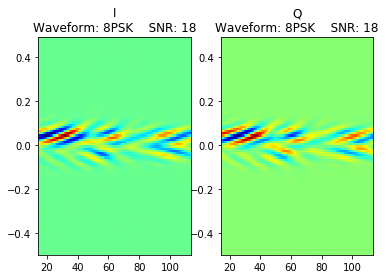

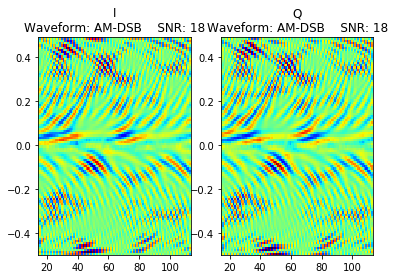

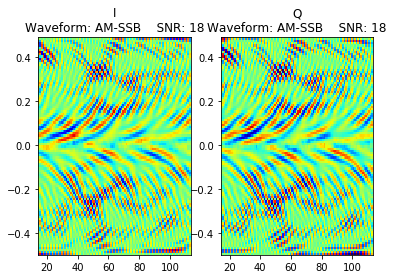

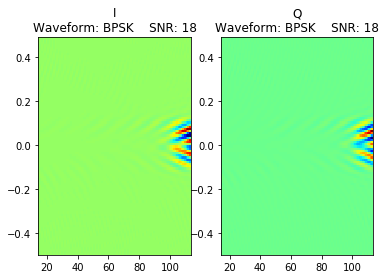

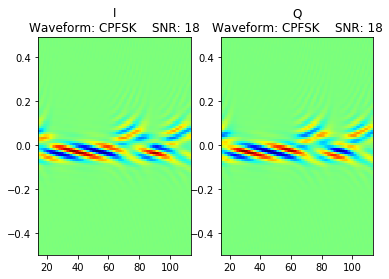

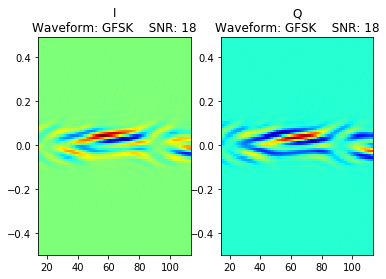

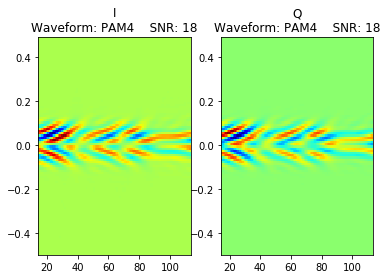

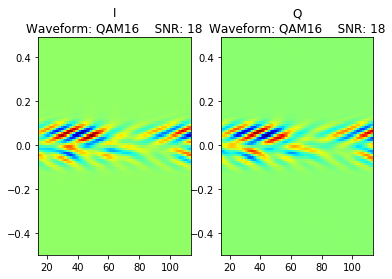

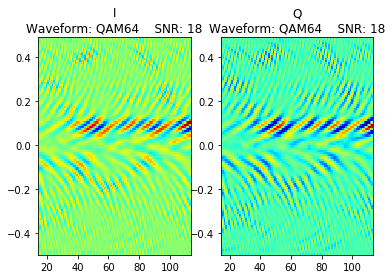

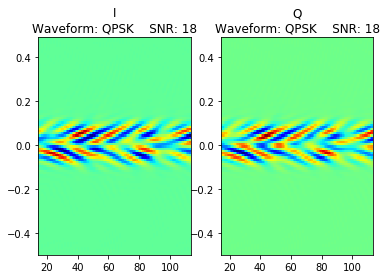

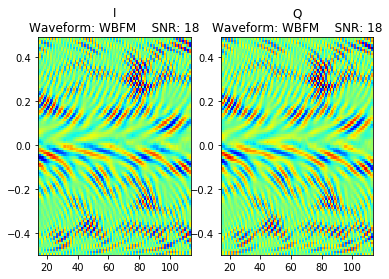

In [6]:
n_ex = spec_dict['y'].size
for i in range(0, n_ex, 1000):
    ut.plot_spectrogram(spec_dict, ex_num=i)

In [7]:
print('There are {} examples in dataset.'.format(spec_dict['x_s'].shape[0]))
print('Spectrograms are of shape: ', spec_dict['x_s'].shape[1:])

There are 11000 examples in dataset.
Spectrograms are of shape:  (100, 100, 2)


## Plot IQ data

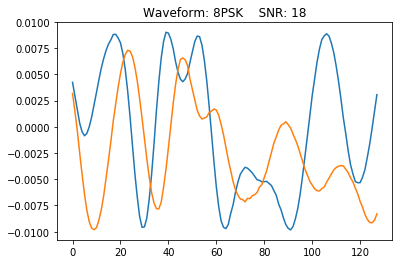

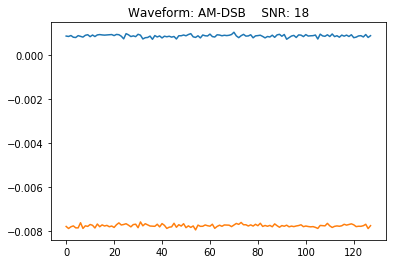

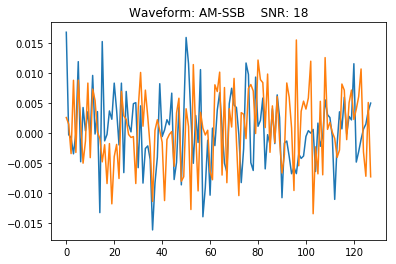

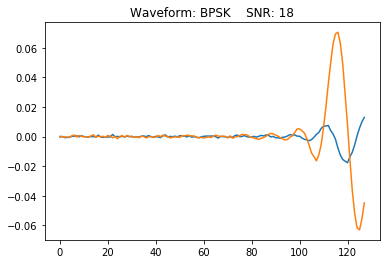

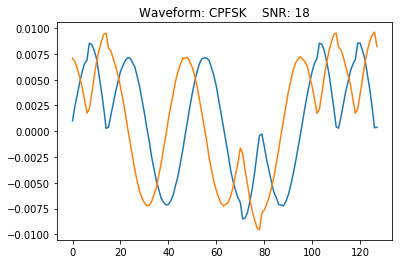

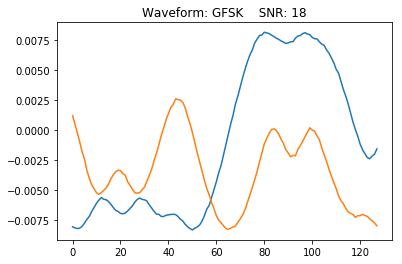

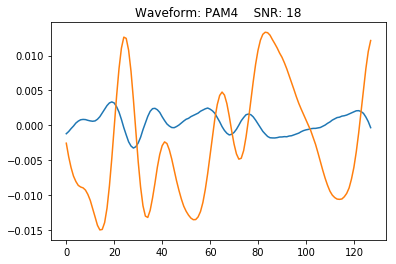

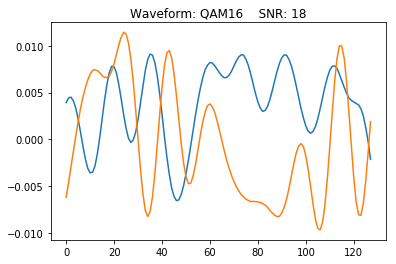

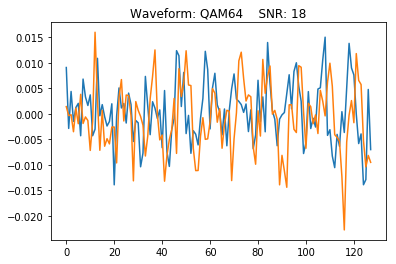

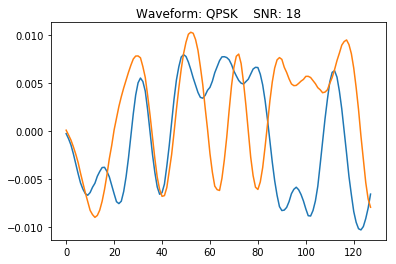

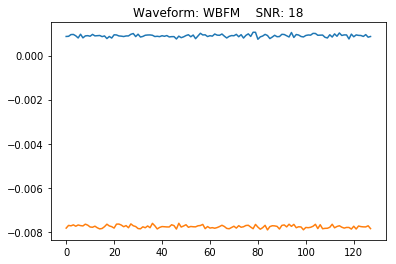

In [8]:
for i in range(0, n_ex, 1000):
    ut.plot_iq(data_dict, ex_num=i)

## Save as pickle file

In [11]:
## data using SNR of 10 dB
filename = '../processed_data/spectrogram_dict_18_IQ'

In [10]:
ut.to_pickle(spec_dict, filename)